# AI-Driven Optimization: Sinusoidal Pressure Strategy

**Objective:** Optimize the parameters of a **Sinusoidal Injection Schedule** to compare against the free-form "Pulse-Relax" strategy.

We define the pressure schedule as:
$$ P(t) = P_{base} + A \cdot \sin(2\pi f t + \phi) $$

The AI will optimize the parameters $\theta = [P_{base}, A, f, \phi]$ to maximize CO2 storage efficiency.

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, value_and_grad, checkpoint
import optax
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# --- 1. Physical Constants (SAME CONFIG) ---
NX, NY = 100, 50       
TIME_STEPS = 1000      

TAU_BRINE = 1.0        
TAU_CO2 = 0.9          # Stable Viscosity
G_INT = -1.0           # Stable Interaction
RHO_BRINE = 1.0        
RHO_CO2_INIT = 0.1     
D_SALT = 0.05          
K_SP = 1.1             

# Lattice Weights
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

print("Environment Configured: Sinusoidal Mode")

Environment Configured: Sinusoidal Mode


## 2. Physics Kernels (Identical to Previous)

In [2]:
@jit
def get_equilibrium(rho, u_x, u_y):
    u_x_exp = jnp.expand_dims(u_x, axis=-1)
    u_y_exp = jnp.expand_dims(u_y, axis=-1)
    rho_exp = jnp.expand_dims(rho, axis=-1)
    u_sq = u_x**2 + u_y**2
    u_sq_exp = jnp.expand_dims(u_sq, axis=-1)
    eu = (CX * u_x_exp + CY * u_y_exp)
    return rho_exp * W * (1.0 + 3.0*eu + 4.5*eu**2 - 1.5*u_sq_exp)

@jit
def interaction_force(rho, G):
    rho_safe = jnp.clip(rho, 1e-3, 5.0)
    psi = 1 - jnp.exp(-rho_safe)
    psi_xp, psi_xm = jnp.roll(psi, -1, axis=0), jnp.roll(psi, 1, axis=0)
    psi_yp, psi_ym = jnp.roll(psi, -1, axis=1), jnp.roll(psi, 1, axis=1)
    fx = -G * psi * (psi_xp - psi_xm)
    fy = -G * psi * (psi_yp - psi_ym)
    return fx, fy

@jit
def collision_stream(f, salt_conc, mask, tau):
    rho = jnp.sum(f, axis=-1)
    rho_safe = jnp.maximum(rho, 1e-3)
    u_x = jnp.sum(f * CX, axis=-1) / rho_safe
    u_y = jnp.sum(f * CY, axis=-1) / rho_safe
    u_x = jnp.clip(u_x, -0.4, 0.4)
    u_y = jnp.clip(u_y, -0.4, 0.4)
    
    fx, fy = interaction_force(rho, G_INT)
    u_x += fx / rho_safe
    u_y += fy / rho_safe
    
    precip_factor = jax.nn.sigmoid(10 * (salt_conc - K_SP)) 
    u_x *= (1.0 - precip_factor) 
    u_y *= (1.0 - precip_factor)

    f_eq = get_equilibrium(rho, u_x, u_y)
    tau_exp = jnp.expand_dims(tau, axis=-1)
    f_out = f - (f - f_eq) / tau_exp
    
    for i in range(9):
        f_out = f_out.at[..., i].set(jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0, 1)))
        
    mask_exp = jnp.expand_dims(mask, axis=-1)
    f_out = f_out * (1 - mask_exp) + f * mask_exp
    return jnp.nan_to_num(f_out, nan=0.0), rho, u_x, u_y

@checkpoint
def lbm_step(carry, pressure_in):
    f, salt, mask = carry
    # --- INLET BC ---
    p_safe = jnp.clip(pressure_in, 0.0, 0.5) 
    rho_inlet = RHO_CO2_INIT + p_safe * 1.0 
    f = f.at[0, :, :].set(get_equilibrium(rho_inlet, 0.1, 0.0))
    
    # --- RELAXATION ---
    rho_local = jnp.sum(f, axis=-1)
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    tau_safe = jnp.maximum(tau_eff, 0.52)
    
    # --- SOLVE ---
    f_new, rho, ux, uy = collision_stream(f, salt, mask, tau_safe)
    
    # --- SALT ---
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + D_SALT * laplacian)
    salt_new = salt_new.at[0, :].set(0.0)
    salt_new = jnp.clip(salt_new, 0.0, 5.0)
    
    # --- PRECIPITATION ---
    new_precip = jax.nn.sigmoid(20 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    pore_vol = jnp.sum(1-mask_new) + 1e-6
    s_co2 = jnp.sum((rho < (RHO_BRINE + RHO_CO2_INIT)/2.0) * (1-mask_new)) / pore_vol
    
    return (jnp.nan_to_num(f_new), salt_new, mask_new), s_co2

def run_simulation(pressure_schedule, initial_state):
    return lax.scan(lbm_step, initial_state, pressure_schedule)

## 3. Parametric Sinusoidal Optimization
Here we differ from the previous notebook. Instead of optimizing an array of 1000 numbers, we optimize **4 parameters**:
1. `base`: Baseline pressure
2. `amp`: Amplitude of the wave
3. `freq`: Frequency (Cycles per 1000 steps)
4. `phase`: Phase shift

In [3]:
def get_sinusoidal_schedule(wave_params):
    """Generates P(t) from parameters [base, amp, freq, phase]"""
    base, amp, freq, phase = wave_params
    t = jnp.arange(TIME_STEPS)
    # Calculate Wave
    # Frequency scaling: freq=1.0 means 1 cycle per simulation
    omega = 2 * jnp.pi * freq / TIME_STEPS 
    pressure = base + amp * jnp.sin(omega * t + phase)
    
    # Physical constraints (Must be positive, safe max)
    return jnp.clip(pressure, 0.0, 0.2)

def loss_fn_parametric(wave_params, initial_state):
    # 1. Generate Schedule from Params
    pressure_schedule = get_sinusoidal_schedule(wave_params)
    
    # 2. Run Simulation
    final_state, s_hist = run_simulation(pressure_schedule, initial_state)
    
    # 3. Compute Loss
    LAMBDA_ENERGY = 0.05
    final_saturation = s_hist[-1]
    perf_loss = (1.0 - final_saturation)**2
    energy_loss = jnp.mean(pressure_schedule**2)
    
    return perf_loss + (LAMBDA_ENERGY * energy_loss)

# --- Initialize ---
key = jax.random.PRNGKey(55)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) 

rho_init = jnp.ones((NX, NY)) * RHO_BRINE 
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 
state_init = (f_init, salt_init, mask_init)

# --- Optimizer Setup ---
# Initial Guess: Base=0.03, Amp=0.01, Freq=10 cycles, Phase=0
init_params = jnp.array([0.03, 0.01, 10.0, 0.0])

optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(init_params)
grad_fn = jit(value_and_grad(loss_fn_parametric))

print("Starting Parametric Optimization (Sinusoidal)...")
print(f"{'Epoch':<6} | {'Loss':<10} | {'Base':<8} | {'Amp':<8} | {'Freq':<8}")
print("-" * 55)

params = init_params
loss_history = []

for epoch in range(51):
    loss_val, grads = grad_fn(params, state_init)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce positive freq/amp/base if needed (Optional)
    params = jnp.abs(params)
    
    loss_history.append(loss_val)
    if epoch % 5 == 0:
        b, a, f, p = params
        print(f"{epoch:<6} | {loss_val:.5f}    | {b:.4f}   | {a:.4f}   | {f:.4f}")

print("Optimization Complete.")

Starting Parametric Optimization (Sinusoidal)...
Epoch  | Loss       | Base     | Amp      | Freq    
-------------------------------------------------------
0      | 0.35103    | 0.0200   | 0.0000   | 10.0097
5      | 0.35189    | 0.0057   | 0.0051   | 10.0403
10     | 0.35405    | 0.0005   | 0.0022   | 10.0651
15     | 0.35189    | 0.0036   | 0.0033   | 10.0854
20     | 0.35343    | 0.0004   | 0.0025   | 10.1009
25     | 0.35189    | 0.0026   | 0.0026   | 10.1124
30     | 0.35343    | 0.0005   | 0.0028   | 10.1198
35     | 0.35189    | 0.0022   | 0.0025   | 10.1233
40     | 0.35343    | 0.0010   | 0.0038   | 10.1237
45     | 0.35250    | 0.0022   | 0.0033   | 10.1207
50     | 0.35343    | 0.0012   | 0.0043   | 10.1159
Optimization Complete.


## 4. Results & Comparison
We visualize the optimized Sinusoidal Schedule and compare it with the Baseline.

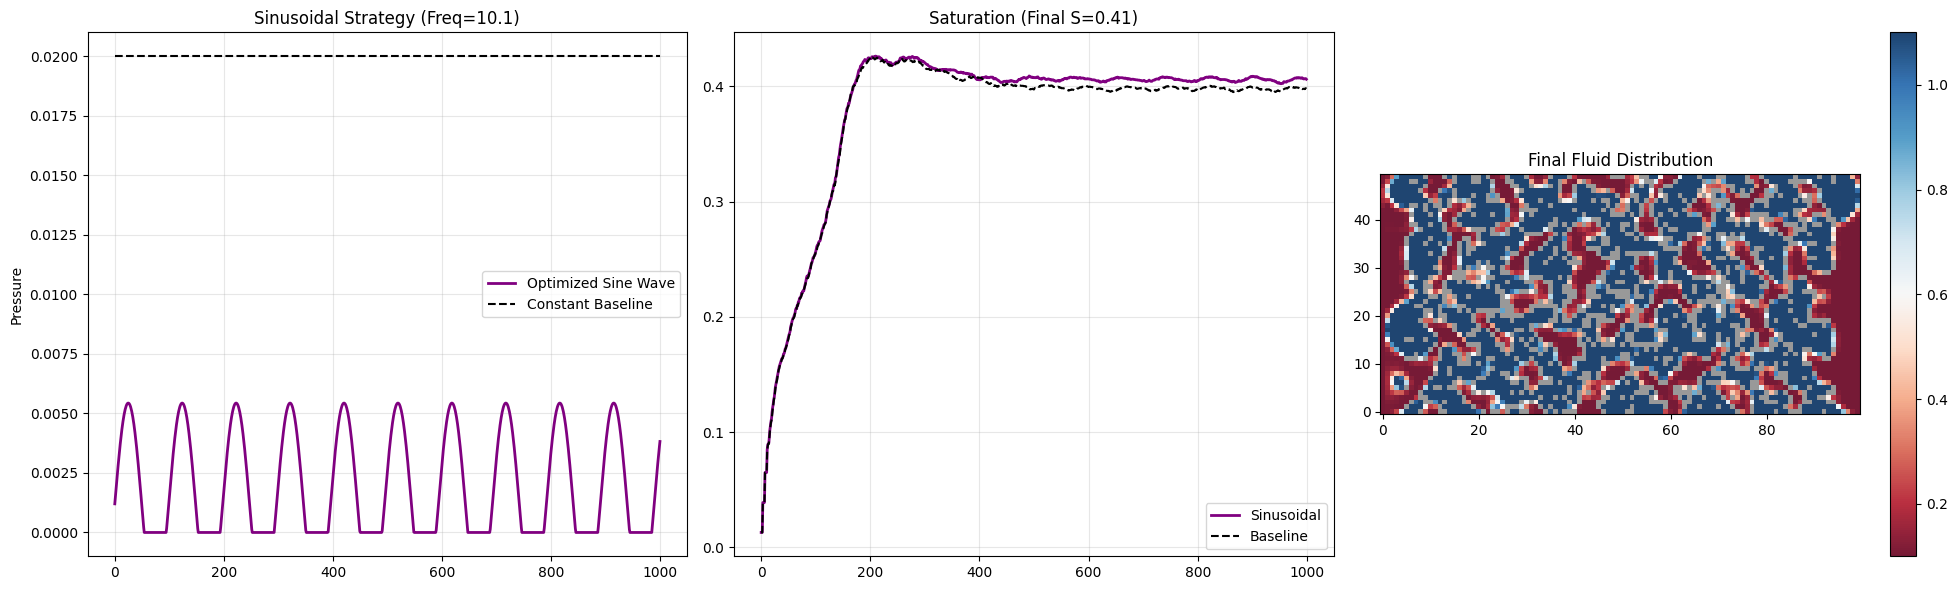

In [4]:
# Generate final optimal schedule
opt_schedule = get_sinusoidal_schedule(params)

# Run Validations
final_state_opt, s_hist_opt = run_simulation(opt_schedule, state_init)
final_state_base, s_hist_base = run_simulation(jnp.ones(TIME_STEPS)*0.02, state_init)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 1. Strategy Comparison
ax[0].plot(opt_schedule, color='purple', linewidth=2, label='Optimized Sine Wave')
ax[0].plot(jnp.ones(TIME_STEPS)*0.02, 'k--', label='Constant Baseline')
ax[0].set_title(f"Sinusoidal Strategy (Freq={params[2]:.1f})")
ax[0].set_ylabel("Pressure")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Efficiency
ax[1].plot(s_hist_opt, color='purple', linewidth=2, label='Sinusoidal')
ax[1].plot(s_hist_base, 'k--', label='Baseline')
ax[1].set_title(f"Saturation (Final S={s_hist_opt[-1]:.2f})")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

# 3. Fluid Map
f_final, _, mask_final = final_state_opt
rho_final = jnp.sum(f_final, axis=-1)
rho_masked = np.ma.masked_where(mask_final > 0.5, rho_final)
ax[2].imshow(jnp.transpose(mask_final), cmap='Greys', origin='lower', alpha=0.4)
im = ax[2].imshow(rho_masked.T, cmap='RdBu', origin='lower', vmin=0.1, vmax=1.1, alpha=0.9)
ax[2].set_title("Final Fluid Distribution")
plt.colorbar(im, ax=ax[2])

plt.tight_layout()
plt.show()